#install packages and load libraries

Install non-native packages



In [ ]:
%%capture
!pip install scikit-learn==0.22.2.post1
!pip install ipynb

Import common packages

In [ ]:
import copy, cProfile, datetime, glob
from itertools import combinations 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle, pstats, shutil, sys
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, average_precision_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, train_test_split
import time

Enable Google Colab, mount drives, and load proprietary modules...

In [ ]:
%%capture
from google.colab import drive, files
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWijzrkd7_Png79w3vBzM85zBDKR9wtLLCZ2s-N9nbumiZkRv8QiJbw


#define file paths and key variables--gw added

In [ ]:
#directories
workDir = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/'
complexesPath = workDir + 'proteinComplexes/'

#get CORUM

In [ ]:
CORUM_complexesData_path = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'

In [ ]:
CORUM_complexesData = pd.read_csv(CORUM_complexesData_path, sep='\t')

In [ ]:
CORUM_complexesData.shape

(3512, 20)

In [ ]:
CORUM_complexesData.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC4,11929873,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC5,11929873,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC7,11929873,B-cell lymphoma 6 protein;Histone deacetylase 7
3,4,Multisubunit ACTR coactivator complex,Human,None,None,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,MI:0004-affinity chromatography technologies;M...,GO:0045893;GO:0023052;GO:0005634,"positive regulation of transcription, DNA-temp...",11.02.03.04.01;30.01;70.10,transcription activation;cellular signalling;n...,"P300;CBP;PCAF;AIB1, BHLHE42, RAC3, TRAM1, ACTR",Cofactor ACTR binds directly nuclear receptors...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,EP300;CREBBP;KAT2B;NCOA3,9267036,Histone acetyltransferase p300;CREB-binding pr...
4,9,6S-nuclear aryl hydrocarbon (Ah) receptor liga...,Mouse,None,None,P30561;P53762,11622;11863,MI:0019- coimmunoprecipitation,GO:2001141;GO:0006355;GO:0003677;GO:0023052;GO...,regulation of RNA biosynthetic process;regulat...,11.02.03.04;16.03.01;30.01;34.11.03;70.10,transcriptional control;DNA binding;cellular s...,;None,"Arnt contains a basic helix-loop-helix motif, ...",None,Mus musculus (Mouse);Mus musculus (Mouse),None,Ahr;Arnt,1317062,Aryl hydrocarbon receptor ;Aryl hydrocarbon re...


In [ ]:
proteinsComplexes_composition = CORUM_complexesData.loc[CORUM_complexesData.Organism=='Human', 'subunits(Entrez IDs)']

In [ ]:
proteinsComplexes_composition.shape

(2417,)

##Characterize CORUM complexes

###Check for Ribosome complex in predicted complexes

In [ ]:
proteinsComplexes_composition = CORUM_complexesData.copy()

In [ ]:
proteinsComplexes_composition.insert(7, 'cliqueSize', np.nan)

for idx in proteinsComplexes_composition.index:
  proteinsComplexes_composition.loc[idx, 'cliqueSize'] = len(proteinsComplexes_composition.loc[idx, 'subunits(Entrez IDs)'].split(';'))

proteinsComplexes_composition.cliqueSize = proteinsComplexes_composition.cliqueSize.astype(int)

In [ ]:
proteinsComplexes_composition.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),cliqueSize,Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,2,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC4,11929873,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,2,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC5,11929873,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,2,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC7,11929873,B-cell lymphoma 6 protein;Histone deacetylase 7
3,4,Multisubunit ACTR coactivator complex,Human,None,None,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,4,MI:0004-affinity chromatography technologies;M...,GO:0045893;GO:0023052;GO:0005634,"positive regulation of transcription, DNA-temp...",11.02.03.04.01;30.01;70.10,transcription activation;cellular signalling;n...,"P300;CBP;PCAF;AIB1, BHLHE42, RAC3, TRAM1, ACTR",Cofactor ACTR binds directly nuclear receptors...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,EP300;CREBBP;KAT2B;NCOA3,9267036,Histone acetyltransferase p300;CREB-binding pr...
4,9,6S-nuclear aryl hydrocarbon (Ah) receptor liga...,Mouse,None,None,P30561;P53762,11622;11863,2,MI:0019- coimmunoprecipitation,GO:2001141;GO:0006355;GO:0003677;GO:0023052;GO...,regulation of RNA biosynthetic process;regulat...,11.02.03.04;16.03.01;30.01;34.11.03;70.10,transcriptional control;DNA binding;cellular s...,;None,"Arnt contains a basic helix-loop-helix motif, ...",None,Mus musculus (Mouse);Mus musculus (Mouse),None,Ahr;Arnt,1317062,Aryl hydrocarbon receptor ;Aryl hydrocarbon re...


In [ ]:
proteinsComplexes_composition.loc[proteinsComplexes_composition.cliqueSize==80]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),cliqueSize,Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
201,306,"Ribosome, cytoplasmic",Human,None,None,P05386;P05387;P05388;P08708;P08865;P15880;P180...,6176;6181;6175;6218;3921;6187;6165;6129;6139;6...,80,MI:0363-inferred by author,GO:0006412;GO:0005737,translation;cytoplasm,12.04;70.03,translation;cytoplasm,RRP1;D11S2243E RPP2;None;RPS17L;LAMBR LAMR1;RP...,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,"Since the authors did not specify RPS4Y, we us...",RPLP1;RPLP2;RPLP0;RPS17;RPSA;RPS2;RPL35A;RPL7;...,14681386,60S acidic ribosomal protein P1;60S acidic rib...
876,1181,C complex spliceosome,Human,None,None,O43290;O43390;O43660;O60306;O60506;O60508;O755...,9092;10236;5356;9716;10492;51362;23451;23020;2...,80,MI:0028- cosedimentation in solution; MI:0096-...,GO:0008380;GO:0003723;GO:0005634,RNA splicing;RNA binding;nucleus,11.04.03.01;16.03.03;70.10,splicing;RNA binding;nucleus,;HNRPR;;KIAA0560;HNRPQ NSAP1;EHB3 PRP17 PRPF17...,"In eukaryotes, the removal of introns from nas...",None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,SART1;HNRNPR;PLRG1;AQR;SYNCRIP;CDC40;SF3B1;SNR...,11991638,U4/U6.U5 tri-snRNP-associated protein 1 ;Heter...


In [ ]:
ribosomeConstituents = proteinsComplexes_composition.loc[201, 'subunits(Entrez IDs)'].split(';')
ribosomeConstituents = [int(i, 10) for i in ribosomeConstituents]

In [ ]:
pickle.dump(ribosomeConstituents, open(complexesPath + 'ribosomeConstituents.pkl', 'wb'))

###main

In [ ]:
cliqueSizes = np.empty((len(proteinsComplexes_composition), ))
cliqueSizes[:] = np.nan

for i, idx in zip(np.arange(len(proteinsComplexes_composition)), proteinsComplexes_composition.index):
  cliqueSizes[i, ] = len(proteinsComplexes_composition.loc[idx].split(';'))

In [ ]:
cliqueSizes.max()

143.0

In [ ]:
cliqueSizes.min()

1.0

In [ ]:
len(np.unique(cliqueSizes))

40

In [ ]:
uniqueClique_sizes, uniqueClique_sizesCounts = np.unique(cliqueSizes, return_counts=True)

In [ ]:
uniqueClique_sizes

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  30.,  31.,  32.,  33.,  36.,  37.,
        44.,  47.,  48.,  78.,  80., 104., 143.])

In [ ]:
uniqueClique_sizesCounts

array([ 60, 727, 844, 270, 139,  62,  55,  46,  31,  36,  20,  20,  20,
        15,  14,  16,   8,   3,   3,   2,   2,   1,   2,   2,   1,   2,
         1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   1,
         1])

In [ ]:
np.sum(uniqueClique_sizesCounts[:15])/np.sum(uniqueClique_sizesCounts)

0.9760033098882913

In [ ]:
uniqueClique_sizes[15]

16.0

<BarContainer object of 40 artists>

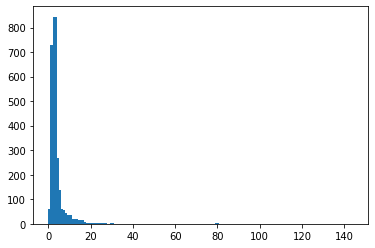

In [ ]:
plt.bar(uniqueClique_sizes, uniqueClique_sizesCounts, width=2)

<BarContainer object of 16 artists>

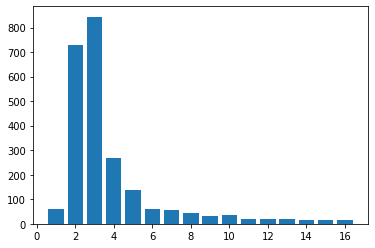

In [ ]:
plt.bar(uniqueClique_sizes[:16], uniqueClique_sizesCounts[:16])

##Find matches between sets of complexes

In [ ]:
modelPerformances_path = workDir + 'modelPerformance/modelsPerformance_'
expName = 'integrated_cell-specific_MM+TSCS+Exp+Abun+Loc+Kaggle+SCBC_5CV'
cellLines = ['h322m', 'mcf7', 'u251']
ppiThresholds = ['top5%', 'top10%', 'top15%', 'top20%', 'top25%']
dirSuffix = '_predictedComplexes'

##trial run-through

In [ ]:
proteinsComplexes_composition_8 = CORUM_complexesData.copy()
proteinsComplexes_composition_8['cliqueSize'] = np.nan
proteinsComplexes_composition_8 = proteinsComplexes_composition_8.loc[CORUM_complexesData.Organism=='Human', ['subunits(Entrez IDs)', 'cliqueSize']]
#print(proteinsComplexes_composition_8.head())

In [ ]:
for idx in proteinsComplexes_composition_8.index:
  proteinsComplexes_composition_8.loc[idx, 'cliqueSize'] = len(proteinsComplexes_composition_8.loc[idx, 'subunits(Entrez IDs)'].split(';'))
#print(proteinsComplexes_composition_8.loc[proteinsComplexes_composition_8.cliqueSize==8.0].shape)
#print(proteinsComplexes_composition_8.loc[proteinsComplexes_composition_8.cliqueSize==8.0].head())

In [ ]:
#proteinsComplexes_composition_8['proteinComplexes_set'] = proteinsComplexes_composition_8['subunits(Entrez IDs)'].str.split(';')
proteinsComplexes_composition_8['proteinComplexes_set'] = proteinsComplexes_composition_8['subunits(Entrez IDs)'].str.split(";").apply(lambda x: [int(i, 10) for i in x if i != 'None'])

In [ ]:
proteinsComplexes_composition_8.iloc[0, 2]

[604, 9759]

In [ ]:
expComplexes = glob.glob(modelPerformances_path + expName + '/' + ppiThresholds[4] + '/' + cellLines[0] + dirSuffix + '/*')
#print(expComplexes[9])
expComplex_data = pd.read_csv(expComplexes[9], sep=',|\t', usecols=list(np.arange(8)), header=None)
#expComplex_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
expSet = set(proteinsComplexes_composition_8.iloc[0, 2])

In [ ]:
expComplex_data.head()

,0,1,2,3,4,5,6,7
0,122704,51081,54148,55052,56945,6150,64928,65003
1,116541,122704,54148,54948,55052,56945,6150,65003
2,116541,122704,54148,55052,56945,6150,64928,65003
3,116541,122704,29088,55052,57129,6150,6182,64928
4,11222,128308,29093,51069,51253,51263,51264,55052


In [ ]:
ctrlSet = set(expComplex_data.iloc[0, :].to_list())

equality

In [ ]:
(ctrlSet==expSet)

False

left set overlap with right set (expSet overlapped with CORUM)

In [ ]:
len(expSet.intersection(ctrlSet))/len(ctrlSet)

0.0

right set overlap with left set (CORUM overlap with expSet)

In [ ]:
len(ctrlSet.intersection(expSet))/len(expSet)

0.0

##Functions

In [ ]:
def compileCORUM_proteinComplexes_relevant(complexesCORUM_dataPath):
  complexesData_CORUM = pd.read_csv(complexesCORUM_dataPath, sep='\t')
  complexesData_CORUM = complexesData_CORUM[complexesData_CORUM['subunits(Entrez IDs)'].str.contains('None')==False]
  complexesData_CORUM = complexesData_CORUM.loc[complexesData_CORUM.Organism=='Human', 'subunits(Entrez IDs)']

  complexCounter = 0
  complexesAll = dict()
  for idx in complexesData_CORUM.index:
    complexesAll[complexCounter] = set(list(map(int, complexesData_CORUM.loc[idx].split(';'))))
    complexCounter+=1

  return complexesAll

In [ ]:
def compileSets_proteinComplexes(dirPath):  
  sets_filenames = glob.glob(dirPath + '/*predicted*txt')
  complexCounter = 0
  complexesAll = dict()
  for filename in sets_filenames:
    complexLen = int(filename.split('_')[-1].split('.')[0])
    sets_dataInd = pd.read_csv(filename, sep=',|\t', usecols=list(np.arange(complexLen)), header=None)

    for idx in sets_dataInd.index:
      complexesAll[complexCounter] = set(sets_dataInd.loc[idx, :].to_list())
      complexCounter+=1

  return complexesAll

In [ ]:
def characterizeOverlap(testDict, refDict):

  setsEqual = 0
  setsContained = 0
  setsOverlapping_less50 = 0
  setsOverlapping_50 = 0
  for testKey in testDict.keys():
    testComplex = testDict[testKey]
    setsOverlapped = []

    for refKey in refDict.keys():
      refComplex = refDict[refKey]

      if testComplex==refComplex:
        setsEqual+=1
      elif testComplex.issubset(refComplex):
        setsContained+=1
      else:
        setsOverlapped.append(len(testComplex.intersection(refComplex))/len(testComplex))
    
    if any(overlap < 0.50 for overlap in setsOverlapped):
      setsOverlapping_less50+=1
    elif any(overlap >= 0.50 for overlap in setsOverlapped):
      setsOverlapping_50+=1

  stats = [setsEqual, setsContained, setsOverlapping_less50, setsOverlapping_50]

  return stats

In [ ]:
len(complexesSets_A_data)

1102

In [ ]:
def assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='Experiment A', complexesSets_B_name='Experiment B', complexLen_max=25, complexesSets_B_isCORUM=False):
  complexesSets_A_data = compileSets_proteinComplexes(complexesSets_A_dirPath) #dictionary
  if not complexesSets_B_isCORUM:
    complexesSets_B_data = compileSets_proteinComplexes(complexesSets_B_dirPath) #dictionary
  else:
    complexesSets_B_data = compileCORUM_proteinComplexes_relevant(complexesSets_B_dirPath) #dictionary
    complexesSets_B_name = 'CORUM'
  
  print('loaded dictionaries...')
  stats = ['Complex constituents', 'Complexes in ' + complexesSets_A_name, 'Complexes in ' + complexesSets_B_name, 'Exact Matches', 'Strict Subsets', 'Overlapping by <50%', 'Overlapping by >=50%']
  complexCmp_stats = pd.DataFrame(columns=stats)
  for complexLen in np.arange(complexLen_max):
    complexesby_lengthCounter = 0
    complexesBy_length = dict()

    for complexSet in complexesSets_A_data.values():
      if len(complexSet) == complexLen:
        complexesBy_length[complexesby_lengthCounter] = complexSet
        complexesby_lengthCounter+=1

    row = characterizeOverlap(complexesBy_length, complexesSets_B_data)
    row.insert(0, complexLen)
    row.insert(1, len(complexesBy_length))
    row.insert(2, sum([1 for val in complexesSets_B_data.values() if len(val) == complexLen]))
    
    complexCmp_statsRow = pd.DataFrame([row], columns=stats)
    complexCmp_stats = complexCmp_stats.append(complexCmp_statsRow)

  return complexCmp_stats

##compare cell-specific predictions against CORUM

In [ ]:
dirPath = modelPerformances_path + expName + '/' + ppiThresholds[4] + '/' + cellLines[0] + dirSuffix

In [ ]:
complexesSets_A_dirPath = modelPerformances_path + expName + '/' + ppiThresholds[0] + '/' + cellLines[0] + dirSuffix
complexesSets_B_dirPath = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'
overlapAnalysis = assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='h322m top 5%', complexesSets_B_name='CORUM', complexLen_max=25, complexesSets_B_isCORUM=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


loaded dictionaries...


In [ ]:
overlapAnalysis.loc[overlapAnalysis['Complex constituents'] > 2, :].to_excel('/content/complexesGenerated_h322m-top20_CORUMcmp.xlsx')

In [ ]:
complexesSets_A_dirPath = modelPerformances_path + expName + '/' + ppiThresholds[4] + '/' + cellLines[0] + dirSuffix
complexesSets_B_dirPath = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'
overlapAnalysis = assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='h322m top 25%', complexesSets_B_name='CORUM', complexLen_max=25, complexesSets_B_isCORUM=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


loaded dictionaries...


In [ ]:
overlapAnalysis.loc[overlapAnalysis['Complex constituents'] > 2, :].to_excel('/content/complexesGenerated_mcf7-top25_CORUMcmp1.xlsx')

In [ ]:
complexesSets_A_dirPath = modelPerformances_path + expName + '/' + ppiThresholds[4] + '/' + cellLines[1] + dirSuffix
complexesSets_B_dirPath = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'
overlapAnalysis = assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='mcf7 top 20%', complexesSets_B_name='CORUM', complexLen_max=25, complexesSets_B_isCORUM=True)

In [ ]:
overlapAnalysis.loc[overlapAnalysis['Complex constituents'] > 2, ['Complex constituents', 'Complexes in mcf7 top 20%', 'Complexes in CORUM', 'Matches', '75% Overlap w/ CORUM', '75% Overlap w/ mcf7 top 20%', '50% Overlap w/ CORUM', '50% Overlap w/ mcf7 top 20%']].to_excel('/content/complexesGenerated_mcf7-top20_CORUMcmp.xlsx')

In [ ]:
complexesSets_A_dirPath = modelPerformances_path + expName + '/' + ppiThresholds[4] + '/' + cellLines[2] + dirSuffix
complexesSets_B_dirPath = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'
overlapAnalysis = assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='u251 top 25%', complexesSets_B_name='CORUM', complexLen_max=25, complexesSets_B_isCORUM=True)

In [ ]:
overlapAnalysis.loc[overlapAnalysis['Complex constituents'] > 2, ['Complex constituents', 'Complexes in u251 top 25%', 'Complexes in CORUM', 'Matches', '75% Overlap w/ CORUM', '75% Overlap w/ u251 top 25%', '50% Overlap w/ CORUM', '50% Overlap w/ u251 top 25%']].to_excel('/content/complexesGenerated_u251-top25_CORUMcmp.xlsx')

In [ ]:
complexesSets_A_dirPath = modelPerformances_path + expName + '/' + ppiThresholds[3] + '/' + cellLines[2] + dirSuffix
complexesSets_B_dirPath = complexesPath + 'coreComplexes_03-09-2018_Corum-3.0 .txt'
overlapAnalysis = assessAgreement_complexesSets(complexesSets_A_dirPath, complexesSets_B_dirPath, complexesSets_A_name='u251 top 20%', complexesSets_B_name='CORUM', complexLen_max=25, complexesSets_B_isCORUM=True)

In [ ]:
overlapAnalysis.loc[overlapAnalysis['Complex constituents'] > 2, ['Complex constituents', 'Complexes in u251 top 20%', 'Complexes in CORUM', 'Matches', '75% Overlap w/ CORUM', '75% Overlap w/ u251 top 20%', '50% Overlap w/ CORUM', '50% Overlap w/ u251 top 20%']].to_excel('/content/complexesGenerated_u251-top20_CORUMcmp.xlsx')

##compare cell-specific predictions against each other